# Monte Carlo race simulation

Loads the trained XGBoost lap-time model plus overtaking, DNF, and safety-car models, then runs repeated race simulations with aggregated results.

In [32]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"

In [33]:

from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import torch
from torch import nn


In [34]:
base_dir = Path.cwd()
if base_dir.name == 'models':
    base_dir = base_dir.parent
bundle_path = base_dir / 'models' / 'laptime_model_bundle.joblib'
if not bundle_path.exists():
    raise FileNotFoundError(f'Missing bundle at {bundle_path}')

# Load Option A bundle and dataset
bundle = joblib.load(bundle_path)

cat_vocabs = bundle["cat_vocabs"]
weather_scaler = bundle["weather_scaler"]
spline = bundle["spline"]
stint_stats = bundle["stint_stats"]
expected_global = float(bundle.get("expected_global", 15.0))
circuit_median_map = bundle.get("circuit_median_map", {})
global_median_lap = float(bundle.get("global_median_lap", 90.0))
driver_counts = bundle.get("driver_counts", {})
driver_shrink_k = float(bundle.get("driver_shrink_k", 2000.0))
track_cols = bundle.get("track_cols", [
    "track_temperature",
    "air_temperature",
    "humidity",
    "pressure",
    "wind_speed",
    "wind_direction",
])
weather_cols = bundle.get("weather_cols", track_cols + ["wet"])
clean_gap_threshold = float(bundle.get("clean_gap_threshold", 2.5))
pit_loss_map = bundle.get("pit_loss_map", {})
pit_loss_mean_global = float(np.mean([v.get('pit_loss_mean', 0.0) for v in pit_loss_map.values()]) or 20.0) if pit_loss_map else 20.0
pit_loss_std_global = float(np.mean([v.get('pit_loss_std', 0.0) for v in pit_loss_map.values() if v.get('pit_loss_std') is not None])) if pit_loss_map else 0.0
if not np.isfinite(pit_loss_std_global):
    pit_loss_std_global = 0.0

pit_loss_floor_vals = [
    v.get('pit_loss_floor')
    for v in pit_loss_map.values()
    if v.get('pit_loss_floor') is not None and np.isfinite(v.get('pit_loss_floor'))
]
pit_loss_floor_global = float(np.mean(pit_loss_floor_vals)) if pit_loss_floor_vals else max(0.0, pit_loss_mean_global - pit_loss_std_global)
if not np.isfinite(pit_loss_floor_global) or pit_loss_floor_global < 0:
    pit_loss_floor_global = 0.0

pit_loss_excess_mean_vals = [
    v.get('pit_excess_mean')
    for v in pit_loss_map.values()
    if v.get('pit_excess_mean') is not None and np.isfinite(v.get('pit_excess_mean'))
]
pit_loss_excess_mean_global = float(np.mean(pit_loss_excess_mean_vals)) if pit_loss_excess_mean_vals else max(0.0, pit_loss_mean_global - pit_loss_floor_global)
if not np.isfinite(pit_loss_excess_mean_global) or pit_loss_excess_mean_global < 0:
    pit_loss_excess_mean_global = max(0.0, pit_loss_mean_global - pit_loss_floor_global)

pit_loss_excess_std_vals = [
    v.get('pit_excess_std')
    for v in pit_loss_map.values()
    if v.get('pit_excess_std') is not None and np.isfinite(v.get('pit_excess_std'))
]
pit_loss_excess_std_global = float(np.mean(pit_loss_excess_std_vals)) if pit_loss_excess_std_vals else pit_loss_std_global
if not np.isfinite(pit_loss_excess_std_global) or pit_loss_excess_std_global < 0:
    pit_loss_excess_std_global = 0.0

noise_sigma_form = float(bundle.get("noise_sigma_form", 0.0))
noise_rho = float(bundle.get("noise_rho", 0.0))
noise_sigma_eta = float(bundle.get("noise_sigma_eta", 0.0))

print(f"Loaded laptime model bundle from {bundle_path}")
# Print noises
print(f"  noise_sigma_form: {noise_sigma_form}")
print(f"  noise_rho: {noise_rho}")
print(f"  noise_sigma_eta: {noise_sigma_eta}")

spline_cols = [f"lap_spline_{i}" for i in range(spline.n_features_out_)]
weather_scaled_cols = [c + "_scaled" for c in weather_cols]


def encode_series(series, vocab):
    return series.astype(str).map(lambda v: vocab.get(v, vocab["__UNK__"])).astype(int)


class CleanPaceModel(nn.Module):
    def __init__(self, vocab_sizes, spline_dim, weather_dim):
        super().__init__()
        self.driver_emb = nn.Embedding(vocab_sizes["driver"], 16)
        self.team_emb = nn.Embedding(vocab_sizes["team"], 8)
        self.circuit_emb = nn.Embedding(vocab_sizes["circuit"], 12)
        self.year_emb = nn.Embedding(vocab_sizes["year"], 4)
        self.session_emb = nn.Embedding(vocab_sizes["session"], 8)
        self.compound_emb = nn.Embedding(vocab_sizes["compound"], 4)

        base_in = 16 + 8 + 12 + 4 + 8
        self.base_linear = nn.Linear(base_in, 1)

        self.fuel_linear = nn.Linear(12, 1)
        self.track_linear = nn.Linear(8, spline_dim)

        tyre_in = 4 + 12 + weather_dim + 1
        self.tyre_mlp = nn.Sequential(
            nn.Linear(tyre_in, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
        )

        self.weather_mlp = nn.Sequential(
            nn.Linear(weather_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

        self.age_norm_weight = nn.Parameter(torch.tensor(0.0))
        self.age_over_weight = nn.Parameter(torch.tensor(0.0))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, batch):
        (
            driver_id, team_id, circuit_id, year_id, session_id, compound_id, driver_weight,
            laps_remaining_norm, tyre_age, age_norm, age_over_norm, expected_len, lap_spline, weather
        ) = batch

        driver_emb_raw = self.driver_emb(driver_id)
        unk_id = torch.zeros_like(driver_id)
        driver_emb_unk = self.driver_emb(unk_id)
        w = driver_weight.unsqueeze(1).clamp(0.0, 1.0)
        driver_emb = w * driver_emb_raw + (1.0 - w) * driver_emb_unk
        team_emb = self.team_emb(team_id)
        circuit_emb = self.circuit_emb(circuit_id)
        year_emb = self.year_emb(year_id)
        session_emb = self.session_emb(session_id)
        compound_emb = self.compound_emb(compound_id)

        base = self.base_linear(torch.cat([driver_emb, team_emb, circuit_emb, year_emb, session_emb], dim=1)).squeeze(1)

        fuel_k = torch.nn.functional.softplus(self.fuel_linear(circuit_emb).squeeze(1))
        fuel = fuel_k * laps_remaining_norm

        track_weights = self.track_linear(session_emb)
        track_evo = (lap_spline * track_weights).sum(dim=1)

        expected_len = torch.clamp(expected_len, min=1e-6)
        tyre_context = torch.cat([compound_emb, circuit_emb, weather, expected_len.unsqueeze(1)], dim=1)
        tyre_params = self.tyre_mlp(tyre_context)
        a = torch.nn.functional.softplus(tyre_params[:, 0])
        b = torch.nn.functional.softplus(tyre_params[:, 1])
        c = torch.nn.functional.softplus(tyre_params[:, 2])
        tau = torch.nn.functional.softplus(tyre_params[:, 3])
        age_term = a * tyre_age + b * (tyre_age ** 2)
        knee = torch.nn.functional.softplus(tyre_age - tau)
        tyre_deg = age_term + c * (knee ** 2)

        extra_age = torch.nn.functional.softplus(self.age_norm_weight) * age_norm
        extra_over = torch.nn.functional.softplus(self.age_over_weight) * age_over_norm

        weather_term = self.weather_mlp(weather).squeeze(1)

        pred = base + fuel + track_evo + tyre_deg + weather_term + extra_age + extra_over + self.bias
        return pred


class TrafficModel(nn.Module):
    def __init__(self, circuit_vocab_size):
        super().__init__()
        self.circuit_emb = nn.Embedding(circuit_vocab_size, 6)
        self.pmax_linear = nn.Linear(6, 1)
        self.g0_linear = nn.Linear(6, 1)
        self.s_raw = nn.Parameter(torch.tensor(0.5))
        self.drs_raw = nn.Parameter(torch.tensor(0.0))

    def forward(self, circuit_id, gap_ahead, drs):
        cemb = self.circuit_emb(circuit_id)
        pmax = torch.nn.functional.softplus(self.pmax_linear(cemb).squeeze(1))
        g0 = torch.nn.functional.softplus(self.g0_linear(cemb).squeeze(1))
        s = torch.nn.functional.softplus(self.s_raw) + 1e-3
        delta_drs = torch.sigmoid(self.drs_raw)
        penalty = pmax * torch.sigmoid((g0 - gap_ahead) / s)
        penalty = penalty * (1 - delta_drs * drs)
        return penalty


vocab_sizes = {
    "driver": len(cat_vocabs["driver_id"]) + 1,
    "team": len(cat_vocabs["team_id"]) + 1,
    "circuit": len(cat_vocabs["circuit_id"]) + 1,
    "year": len(cat_vocabs["year"]) + 1,
    "session": len(cat_vocabs["session_key"]) + 1,
    "compound": len(cat_vocabs["tyre_compound"]) + 1,
}

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

clean_model = CleanPaceModel(vocab_sizes, spline_dim=len(spline_cols), weather_dim=len(weather_scaled_cols)).to(device)
clean_model.load_state_dict(bundle["clean_model_state_dict"])
clean_model.eval()

traffic_model = TrafficModel(vocab_sizes["circuit"]).to(device)
traffic_model.load_state_dict(bundle["traffic_model_state_dict"])
traffic_model.eval()


# Load dataset for grid, team mapping, and defaults
csv_candidates = [Path("fastf1_lap_dataset.csv"), Path("models/fastf1_lap_dataset.csv")]
csv_path = next((p for p in csv_candidates if p.exists()), None)
if csv_path is None:
    raise FileNotFoundError("fastf1_lap_dataset.csv not found")

df = pd.read_csv(csv_path)

for col in ["safety_car_this_lap", "virtual_sc_this_lap"]:
    if col in df.columns:
        df[col] = df[col].fillna(False).astype(bool)
    else:
        df[col] = False

skill_df = df[(~df["safety_car_this_lap"]) & (~df["virtual_sc_this_lap"]) & df["lap_time_s"].notna()].copy()

session_stats = (
    skill_df
    .groupby("session_key")["lap_time_s"]
    .agg(session_median_lap="median", session_std_lap="std")
    .reset_index()
)

skill_df = skill_df.merge(session_stats, on="session_key", how="left")
skill_df["session_std_lap"] = skill_df["session_std_lap"].replace(0, np.nan)
skill_df["session_perf_z"] = -(
    skill_df["lap_time_s"] - skill_df["session_median_lap"]
) / skill_df["session_std_lap"]
skill_df["session_perf_z"] = skill_df["session_perf_z"].fillna(0.0)

driver_skill_raw = skill_df.groupby("driver_id")["session_perf_z"].mean()
driver_skill = (driver_skill_raw - driver_skill_raw.mean()) / driver_skill_raw.std()
driver_skill_map = driver_skill.fillna(0.0).to_dict()


def mode_or_first(series):
    if series.empty:
        return None
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    return series.iloc[0]


driver_team_map = df.groupby("driver_id")["team_id"].apply(mode_or_first).to_dict()
team_by_year = (
    df.groupby(["year", "driver_id"])["team_id"].apply(mode_or_first).to_dict()
)
team_by_session = (
    df.groupby(["session_key", "driver_id"])["team_id"].apply(mode_or_first).to_dict()
)

session_key_map = (
    df
    .groupby(["circuit_id", "year"])["session_key"]
    .apply(mode_or_first)
    .to_dict()
)

default_session_key = mode_or_first(df["session_key"])
session_vocab = cat_vocabs["session_key"]
if default_session_key not in session_vocab:
    candidates = [k for k in session_vocab.keys() if k != "__UNK__"]
    default_session_key = candidates[0] if candidates else "__UNK__"

def lookup_session_key(circuit_id, year):
    key = session_key_map.get((circuit_id, year), default_session_key)
    if key not in session_vocab:
        key = default_session_key
    return key


weather_defaults = {}
for col in track_cols:
    if col in df.columns:
        weather_defaults[col] = float(pd.to_numeric(df[col], errors="coerce").median())
    else:
        weather_defaults[col] = 0.0

# Build a simple grid from the last session (order by first lap position)
last_session_key = df["session_key"].iloc[-1000]
grid_source = df[df["session_key"] == last_session_key]
first_lap_rows = grid_source[grid_source["lap_number"] == grid_source["lap_number"].min()]
grid_drivers = (
    first_lap_rows.sort_values("current_position")["driver_id"].drop_duplicates().tolist()
)
print(f"Grid built from session {last_session_key}: {grid_drivers}")

Loaded laptime model bundle from /Users/ekazuki/Documents/f1stuff/models/laptime_model_bundle.joblib
  noise_sigma_form: 1.262423015110957
  noise_rho: 0.5811747359445667
  noise_sigma_eta: 4.257137545151305
Grid built from session 2025_united_states_grand_prix_race: ['VER', 'LEC', 'NOR', 'HAM', 'PIA', 'RUS', 'ANT', 'BEA', 'SAI', 'TSU', 'HUL', 'ALO', 'LAW', 'GAS', 'OCO', 'BOR', 'COL', 'STR', 'HAD', 'ALB']


In [35]:

pit_loss_table = (
    pd.DataFrame.from_dict(pit_loss_map, orient="index")
    .reset_index()
    .rename(columns={"index": "circuit_id"})
)
pit_loss_table = pit_loss_table[["circuit_id", "pit_loss_floor", "pit_loss_mean", "pit_loss_std"]]
pit_loss_table = pit_loss_table.sort_values("circuit_id")
print("Pit loss stats by circuit:")
print(pit_loss_table.to_string(index=False))

Pit loss stats by circuit:
       circuit_id  pit_loss_floor  pit_loss_mean  pit_loss_std
           austin        16.27720      19.412486      2.268139
             baku        17.86720      20.836648      2.323883
        barcelona        18.73300      21.500921      2.006490
         budapest        16.99325      20.121457      2.292499
       hockenheim        11.28500      22.150608     10.583783
            imola        25.03250      27.977363      2.665918
         istanbul        11.96760      19.182604      4.753966
           jeddah        15.76045      19.463706      2.084086
        las_vegas        17.00600      20.816015      2.407356
     le_castellet        19.66675      23.823197      2.769556
           lusail        23.92450      26.957075      2.476981
       marina_bay        20.41050      26.217804      4.868991
        melbourne        18.40940      21.575611      3.529578
      mexico_city        18.54750      21.684868      2.153595
            miami        17.

In [36]:
cat_cols = ['driver_id', 'team_id', 'circuit_id', 'year', 'session_key', 'tyre_compound']

from pathlib import Path
# Initialize shared RNG and helper models
master_rng = np.random.default_rng(12345)

def _phase(progress):
    if progress < 0.33:
        return "early"
    if progress < 0.66:
        return "middle"
    return "late"

overtake_path = Path("models/overtaking_model.joblib")
if not overtake_path.exists():
    raise FileNotFoundError("Missing models/overtaking_model.joblib. Run models/overtaking_model.ipynb to train/export.")
overtake_bundle = joblib.load(overtake_path)
overtake_pipeline = overtake_bundle.get("pipeline")
overtake_include_year = bool(overtake_bundle.get("include_year", True))
overtake_gap_threshold = float(overtake_bundle.get("gap_threshold", 1.0))
overtake_base_rate = float(overtake_bundle.get("base_rate", 0.05))

def overtake_success_probability(attacker_state, defender_state, circuit_id, gap_start, year=None):
    if overtake_pipeline is None:
        return float(np.clip(overtake_base_rate, 0.01, 0.95))

    def _safe_num(value, default=0.0):
        if value is None or pd.isna(value):
            return default
        return float(value)

    skill_att = float(driver_skill_map.get(attacker_state.get("driver_id"), 0.0))
    skill_def = float(driver_skill_map.get(defender_state.get("driver_id"), 0.0))
    skill_diff = skill_att - skill_def

    att_laps = _safe_num(attacker_state.get("laps_on_current_tyre", 0.0), 0.0)
    def_laps = _safe_num(defender_state.get("laps_on_current_tyre", att_laps), att_laps)
    tyre_adv_laps = def_laps - att_laps

    gap_value = _safe_num(gap_start, overtake_gap_threshold)

    feature_row = {
        "circuit_id": str(circuit_id) if circuit_id is not None else "unknown",
        "gap_start": float(max(gap_value, 0.0)),
        "tyre_age_diff": float(tyre_adv_laps),
        "skill_diff": float(skill_diff),
    }
    if overtake_include_year:
        if year is None or pd.isna(year):
            year_value = "unknown"
        else:
            try:
                year_value = str(int(year))
            except (TypeError, ValueError):
                year_value = str(year)
        feature_row["year"] = year_value

    X = pd.DataFrame([feature_row])
    prob = float(overtake_pipeline.predict_proba(X)[0, 1])
    return float(np.clip(prob, 0.01, 0.95))

def apply_overtakes_for_lap(
    circuit_id,
    drivers_by_pos,
    lap_times,
    base_lap,
    year=None,
    close_gap_threshold=None,
    fail_gap=0.4,
    rng=None,
):
    """Apply overtaking effects to one lap prediction for ordered drivers."""
    lap_times = np.asarray(lap_times, dtype=float).copy()
    n = len(drivers_by_pos)

    overtake_attempts = np.zeros(n, dtype=bool)
    if close_gap_threshold is None:
        close_gap_threshold = overtake_gap_threshold

    rng = rng or master_rng

    for idx in range(1, n):
        follower = drivers_by_pos[idx]
        leader = drivers_by_pos[idx - 1]

        gap_start = float(follower["gap_to_ahead"])
        leader_time = lap_times[idx - 1]
        follower_time = lap_times[idx]
        gap_end_raw = gap_start + (follower_time - leader_time)

        going_to_pass_raw = gap_end_raw < 0.0
        close_enough = gap_start <= close_gap_threshold

        if not going_to_pass_raw and not close_enough:
            continue

        overtake_attempts[idx] = True

        margin = max(0.0, -gap_end_raw)
        p_success = overtake_success_probability(
            attacker_state=follower,
            defender_state=leader,
            circuit_id=circuit_id,
            gap_start=gap_start,
            year=year,
        )
        p_success = float(min(0.99, p_success + 0.15 * min(margin / 0.5, 1.0)))

        success = (rng.random() < p_success) and going_to_pass_raw
        if success:
            continue

        desired_follower_time = leader_time + fail_gap - gap_start
        if desired_follower_time > follower_time:
            lap_times[idx] = desired_follower_time

    pred_deltas = lap_times - float(base_lap)
    return lap_times, pred_deltas, overtake_attempts

dnf_path = Path("models/dnf_model.joblib")
if not dnf_path.exists():
    raise FileNotFoundError("Missing models/dnf_model.joblib. Run models/dnf_model.ipynb to train/export.")
dnf_bundle = joblib.load(dnf_path)
dnf_pipeline = dnf_bundle["pipeline"]
dnf_include_year = bool(dnf_bundle.get("include_year", True))
dnf_avg_total_laps = float(dnf_bundle.get("avg_total_laps", 50.0))

def dnf_hazard(circuit_id, lap_number, year=None, total_race_laps=None):
    total_laps = float(total_race_laps) if total_race_laps else float(dnf_avg_total_laps or 1.0)
    lap_num = float(lap_number or 0)
    progress = lap_num / total_laps if total_laps > 0 else 0.0

    data = {
        "circuit_id": str(circuit_id) if circuit_id is not None else "unknown",
        "lap_number": lap_num,
        "total_race_laps": total_laps,
        "progress": progress,
    }
    if dnf_include_year:
        data["year"] = str(year) if year is not None else "unknown"
    X = pd.DataFrame([data])
    prob = float(dnf_pipeline.predict_proba(X)[0, 1])
    return float(np.clip(prob, 1e-6, 0.5))

def apply_dnfs_for_lap(circuit_id, drivers_by_pos, lap_number, year=None, total_race_laps=None, rng=None):
    rng = rng or master_rng
    h = dnf_hazard(circuit_id, lap_number, year=year, total_race_laps=total_race_laps)
    dnfs_this_lap = []
    for driver in drivers_by_pos:
        if driver.get("dnf", False):
            dnfs_this_lap.append(False)
            continue
        dnf_now = bool(rng.random() < h)
        dnfs_this_lap.append(dnf_now)
        if dnf_now:
            driver["dnf"] = True
    return drivers_by_pos, dnfs_this_lap

safety_path = Path("models/safety_car_model.joblib")
if not safety_path.exists():
    raise FileNotFoundError("Missing models/safety_car_model.joblib. Run models/safety_car_model.ipynb to train/export.")
safety_bundle = joblib.load(safety_path)
safety_pipeline = safety_bundle["pipeline"]
safety_include_year = bool(safety_bundle.get("include_year", True))
safety_max_len_bucket = int(safety_bundle.get("max_len_bucket", 12))

def sc_transition_probs(state, stint_len, circuit_id, year, progress, lap_number):
    stint_bucket = 0 if state == "green" else min(int(stint_len), safety_max_len_bucket)
    phase = _phase(progress)
    row = {
        "state": state,
        "stint_bucket": float(stint_bucket),
        "race_progress": float(progress),
        "lap_number": float(lap_number),
        "circuit_id": str(circuit_id) if circuit_id is not None else "unknown",
        "phase": phase,
    }
    if safety_include_year:
        if year is None or pd.isna(year):
            year_value = "unknown"
        else:
            try:
                year_value = str(int(year))
            except (TypeError, ValueError):
                year_value = str(year)
        row["year"] = year_value
    else:
        row["year"] = "unknown"
    X = pd.DataFrame([row])
    probs = safety_pipeline.predict_proba(X)[0]
    class_map = dict(zip(safety_pipeline.classes_, probs))
    return {
        "green": float(class_map.get("green", 0.0)),
        "vsc": float(class_map.get("vsc", 0.0)),
        "sc": float(class_map.get("sc", 0.0)),
    }

def sc_next_state(state, stint_len, circuit_id, year, progress, lap_number, rng=None):
    rng = rng or master_rng
    probs = sc_transition_probs(state, stint_len, circuit_id, year, progress, lap_number)
    r = rng.random()
    if r < probs["green"]:
        next_state = "green"
    elif r < probs["green"] + probs["vsc"]:
        next_state = "vsc"
    else:
        next_state = "sc"

    if next_state == state and state in ("vsc", "sc"):
        next_len = int(stint_len) + 1
    elif next_state in ("vsc", "sc"):
        next_len = 1
    else:
        next_len = 0
    return next_state, next_len





In [37]:


def encode_value(value, vocab):
    return vocab.get(str(value), vocab["__UNK__"])


EXPECTED_STINT_MAP = {}
if 'expected_stint_len' in stint_stats.columns:
    EXPECTED_STINT_MAP = (
        stint_stats.set_index(["circuit_id", "tyre_compound"])["expected_stint_len"].to_dict()
    )


def predict_clean_and_traffic_fast(
    driver_id_ids,
    team_id_ids,
    circuit_id_ids,
    year_id_ids,
    session_id_ids,
    compound_ids,
    driver_weight,
    laps_remaining_norm,
    tyre_age,
    age_norm,
    age_over_norm,
    expected_len,
    lap_spline,
    weather_scaled,
    gap_ahead,
    drs,
):
    with torch.no_grad():
        features = [
            torch.tensor(driver_id_ids, dtype=torch.long, device=device),
            torch.tensor(team_id_ids, dtype=torch.long, device=device),
            torch.tensor(circuit_id_ids, dtype=torch.long, device=device),
            torch.tensor(year_id_ids, dtype=torch.long, device=device),
            torch.tensor(session_id_ids, dtype=torch.long, device=device),
            torch.tensor(compound_ids, dtype=torch.long, device=device),
            torch.tensor(driver_weight, dtype=torch.float32, device=device),
            torch.tensor(laps_remaining_norm, dtype=torch.float32, device=device),
            torch.tensor(tyre_age, dtype=torch.float32, device=device),
            torch.tensor(age_norm, dtype=torch.float32, device=device),
            torch.tensor(age_over_norm, dtype=torch.float32, device=device),
            torch.tensor(expected_len, dtype=torch.float32, device=device),
            torch.tensor(lap_spline, dtype=torch.float32, device=device),
            torch.tensor(weather_scaled, dtype=torch.float32, device=device),
        ]
        clean_pred = clean_model(features).detach().cpu().numpy()

        circuit_t = torch.tensor(circuit_id_ids, dtype=torch.long, device=device)
        gap_t = torch.tensor(gap_ahead, dtype=torch.float32, device=device)
        drs_t = torch.tensor(drs, dtype=torch.float32, device=device)
        traffic_pred = traffic_model(circuit_t, gap_t, drs_t).detach().cpu().numpy()

    return clean_pred, traffic_pred




def apply_overtakes_for_lap(
    circuit_id,
    drivers_by_pos,
    lap_times,
    base_lap,
    year=None,
    close_gap_threshold=None,
    fail_gap=0.3,
    rng=None,
):
    lap_times = np.asarray(lap_times, dtype=float).copy()
    base_lap = float(base_lap)
    n = len(drivers_by_pos)

    overtake_attempts = np.zeros(n, dtype=bool)
    if close_gap_threshold is None:
        close_gap_threshold = overtake_gap_threshold

    rng = rng or master_rng

    for idx in range(1, n):
        follower = drivers_by_pos[idx]
        leader = drivers_by_pos[idx - 1]

        gap_start = float(follower["gap_to_ahead"])
        leader_time = lap_times[idx - 1]
        follower_time = lap_times[idx]
        gap_end_raw = gap_start + (follower_time - leader_time)

        going_to_pass_raw = gap_end_raw < 0.0
        close_enough = gap_start <= close_gap_threshold

        if not going_to_pass_raw and not close_enough:
            continue

        overtake_attempts[idx] = True

        margin = max(0.0, -gap_end_raw)
        p_success = overtake_success_probability(
            attacker_state=follower,
            defender_state=leader,
            circuit_id=circuit_id,
            gap_start=gap_start,
            year=year,
        )
        p_success = float(min(0.99, p_success + 0.15 * min(margin / 0.5, 1.0)))

        success = (rng.random() < p_success) and going_to_pass_raw
        if success:
            continue

        desired_follower_time = leader_time + fail_gap - gap_start
        if desired_follower_time > follower_time:
            lap_times[idx] = desired_follower_time

    pred_deltas = lap_times - base_lap
    return lap_times, pred_deltas, overtake_attempts


def simulate_race(
    circuit_id,
    grid_drivers,
    total_laps=50,
    year=2025,
    global_strategy=None,
    driver_strategies=None,
    safety_car_laps=None,
    rain_laps=None,
    pit_loss=None,
    rng=None,
):
    # Simulate a race and return (race_log_df, safety_car_lap_set).

    rng = rng or np.random.default_rng()

    base_seed = int(rng.integers(0, 1_000_000_000))
    sc_rng = np.random.default_rng(base_seed + 2)
    overtake_rng = np.random.default_rng(base_seed + 3)
    dnf_rng = np.random.default_rng(base_seed + 4)
    pit_rng = np.random.default_rng(base_seed + 6)

    noise_by_driver = {}
    if noise_sigma_form > 0 or noise_sigma_eta > 0:
        noise_rng = np.random.default_rng(base_seed + 5)
        for drv in grid_drivers:
            form = float(noise_rng.normal(0.0, noise_sigma_form))
            eps = 0.0
            lap_noise = []
            for _ in range(total_laps):
                eps = noise_rho * eps + noise_rng.normal(0.0, noise_sigma_eta)
                lap_noise.append(form + eps)
            noise_by_driver[drv] = lap_noise

    if global_strategy is None:
        raise ValueError("global_strategy must be provided, e.g. [(20, 'MEDIUM'), (40, 'SOFT')]")
    if driver_strategies is None:
        driver_strategies = {}

    if safety_car_laps is None:
        auto_sc_laps = set()
        state, stint_len = 'green', 0
        for lap in range(1, total_laps + 1):
            if state == 'sc':
                auto_sc_laps.add(lap)
            progress = lap / total_laps
            state, stint_len = sc_next_state(state, stint_len, circuit_id, year, progress, lap, rng=sc_rng)
        safety_car_laps = auto_sc_laps
    else:
        safety_car_laps = set(safety_car_laps)

    if rain_laps is None:
        rain_laps = set()
    else:
        rain_laps = set(rain_laps)

    session_key = lookup_session_key(circuit_id, year)
    circuit_id_id = encode_value(circuit_id, cat_vocabs["circuit_id"])
    year_id = encode_value(year, cat_vocabs["year"])
    session_id = encode_value(session_key, cat_vocabs["session_key"])

    expected_by_compound = {
        comp: float(val)
        for (circuit, comp), val in EXPECTED_STINT_MAP.items()
        if circuit == circuit_id
    }
    compound_vocab = cat_vocabs["tyre_compound"]

    lap_progress = np.arange(1, total_laps + 1) / total_laps
    lap_progress_df = pd.DataFrame({"lap_progress": lap_progress})
    spline_by_lap = spline.transform(lap_progress_df)
    laps_remaining_norm_by_lap = (total_laps - np.arange(1, total_laps + 1)) / total_laps

    weather_vals = []
    for col in weather_cols:
        if col == "wet":
            weather_vals.append(0.0)
        else:
            weather_vals.append(weather_defaults.get(col, 0.0))
    weather_scaled_vec = weather_scaler.transform(pd.DataFrame([weather_vals], columns=weather_cols))[0]

    def lookup_team_id(driver_id):
        team_id = team_by_session.get((session_key, driver_id))
        if team_id is None:
            team_id = team_by_year.get((year, driver_id))
        if team_id is None:
            team_id = driver_team_map.get(driver_id)
        return team_id

    def resolve_strategy(strat, rng):
        stops_map = {}
        starting_tyre = None
        for item in strat:
            if len(item) == 2:
                lap, compound = item
                lap = int(lap)
                if lap == 0:
                    starting_tyre = compound
                else:
                    stops_map[lap] = compound
            elif len(item) == 3:
                start, end, compound = item
                start = int(start)
                end = int(end)
                if start > end:
                    start, end = end, start
                if start <= 0 <= end:
                    raise ValueError('Pit window cannot include lap 0; use (0, compound) for starting tyre')
                window_laps = [lap for lap in range(start, end + 1) if lap > 0 and lap <= total_laps]
                if not window_laps:
                    continue
                lap = int(rng.integers(window_laps[0], window_laps[-1] + 1))
                if lap in stops_map:
                    for candidate in window_laps:
                        if candidate not in stops_map:
                            lap = candidate
                            break
                stops_map[lap] = compound
            else:
                raise ValueError('Strategy entries must be (lap, compound) or (start, end, compound)')

        if starting_tyre is None:
            raise ValueError('Strategy must include lap 0 entry for starting tyre')
        return starting_tyre, stops_map

    grid_pos_map = {drv: idx + 1 for idx, drv in enumerate(grid_drivers)}

    drivers_state = []
    for idx, drv in enumerate(grid_drivers):
        strat = driver_strategies.get(drv, global_strategy)
        starting_tyre, stops_map = resolve_strategy(strat, pit_rng)
        drivers_state.append(
            {
                "driver_id": drv,
                "team_id": lookup_team_id(drv),
                "driver_id_id": encode_value(drv, cat_vocabs["driver_id"]),
                "team_id_id": encode_value(lookup_team_id(drv), cat_vocabs["team_id"]),
                "driver_weight": float(driver_counts.get(drv, 0.0)) / (float(driver_counts.get(drv, 0.0)) + driver_shrink_k),
                "grid_position": idx + 1,
                "position": idx + 1,
                "cumul_time": float(idx * 0.3),
                "laps_on_current_tyre": 1,
                "tyre_compound": starting_tyre,
                "gap_to_ahead": 0.0,
                "stops": stops_map,
                "history": [],
                "dnf": False,
            }
        )

    race_log = []
    pit_losses = []

    for lap in range(1, total_laps + 1):
        prev_positions = {s["driver_id"]: s["position"] for s in drivers_state}
        drivers_by_pos = sorted(
            [s for s in drivers_state if not s.get("dnf", False)],
            key=lambda s: s["position"],
        )

        for idx, s in enumerate(drivers_by_pos):
            if idx == 0:
                s["gap_to_ahead"] = 0.0
            else:
                ahead = drivers_by_pos[idx - 1]
                s["gap_to_ahead"] = s["cumul_time"] - ahead["cumul_time"]

        n = len(drivers_by_pos)
        laps_on_tyre_for_update = []
        gap_ahead = np.zeros(n, dtype=float)
        drs = np.zeros(n, dtype=float)
        tyre_age = np.zeros(n, dtype=float)
        expected_len = np.zeros(n, dtype=float)
        compound_ids = np.zeros(n, dtype=int)
        driver_id_ids = np.zeros(n, dtype=int)
        team_id_ids = np.zeros(n, dtype=int)
        driver_weight = np.zeros(n, dtype=float)

        for idx, s in enumerate(drivers_by_pos):
            tyre_age_feature = s["laps_on_current_tyre"]
            laps_on_current_tyre_next = tyre_age_feature + 1
            gap_val = float(s["gap_to_ahead"])
            drs_enabled = 1 if (lap >= 3 and gap_val <= 1.0) else 0

            exp_len = expected_by_compound.get(s["tyre_compound"], expected_global)

            gap_ahead[idx] = gap_val
            drs[idx] = drs_enabled
            tyre_age[idx] = float(tyre_age_feature)
            expected_len[idx] = float(exp_len)
            compound_ids[idx] = compound_vocab.get(str(s["tyre_compound"]), compound_vocab["__UNK__"])
            driver_id_ids[idx] = s["driver_id_id"]
            team_id_ids[idx] = s["team_id_id"]
            driver_weight[idx] = s["driver_weight"]

            laps_on_tyre_for_update.append(laps_on_current_tyre_next)

        age_norm = tyre_age / np.maximum(expected_len, 1e-6)
        age_over = np.clip(tyre_age - expected_len, 0.0, None)
        age_over_norm = age_over / np.maximum(expected_len, 1e-6)

        lap_spline = np.tile(spline_by_lap[lap - 1], (n, 1))
        laps_remaining_norm = np.full(n, laps_remaining_norm_by_lap[lap - 1], dtype=float)
        weather_scaled = np.tile(weather_scaled_vec, (n, 1))
        circuit_id_ids = np.full(n, circuit_id_id, dtype=int)
        year_id_ids = np.full(n, year_id, dtype=int)
        session_id_ids = np.full(n, session_id, dtype=int)

        clean_pred, traffic_pred = predict_clean_and_traffic_fast(
            driver_id_ids,
            team_id_ids,
            circuit_id_ids,
            year_id_ids,
            session_id_ids,
            compound_ids,
            driver_weight,
            laps_remaining_norm,
            tyre_age,
            age_norm,
            age_over_norm,
            expected_len,
            lap_spline,
            weather_scaled,
            gap_ahead,
            drs,
        )
        clean_pred = np.asarray(clean_pred, dtype=float)
        traffic_pred = np.asarray(traffic_pred, dtype=float)
        base_lap = circuit_median_map.get(circuit_id, global_median_lap)
        lap_times = base_lap + clean_pred + traffic_pred

        safety_car_active = lap in safety_car_laps
        if safety_car_active:
            lap_times = np.asarray(lap_times, dtype=float)
            leader_time = lap_times[0] * 1.35
            sc_lap_times = [leader_time]
            for idx in range(1, len(drivers_by_pos)):
                candidate = float(lap_times[idx])
                start_gap = float(drivers_by_pos[idx]["gap_to_ahead"])
                gap_end = start_gap + (candidate - sc_lap_times[idx - 1])
                if gap_end < 0.0:
                    candidate = candidate + abs(gap_end) + 0.3
                sc_lap_times.append(candidate)
            lap_times = np.array(sc_lap_times)
            pred_deltas = lap_times - base_lap
            overtake_attempts = np.zeros(len(drivers_by_pos), dtype=bool)
        else:
            if noise_by_driver:
                lap_times = np.asarray(lap_times, dtype=float)
                for idx, s in enumerate(drivers_by_pos):
                    noise_seq = noise_by_driver.get(s["driver_id"])
                    if noise_seq is not None and lap - 1 < len(noise_seq):
                        lap_times[idx] += float(noise_seq[lap - 1])
            lap_times, pred_deltas, overtake_attempts = apply_overtakes_for_lap(
                circuit_id=circuit_id,
                drivers_by_pos=drivers_by_pos,
                lap_times=lap_times,
                base_lap=base_lap,
                year=year,
                close_gap_threshold=1.0,
                fail_gap=0.3,
                rng=overtake_rng,
            )

        drivers_by_pos, dnfs_this_lap = apply_dnfs_for_lap(
            circuit_id=circuit_id,
            drivers_by_pos=drivers_by_pos,
            lap_number=lap,
            total_race_laps=total_laps,
            year=year,
            rng=dnf_rng,
        )

        attempts_this_lap = {
            drivers_by_pos[i]["driver_id"]: bool(overtake_attempts[i])
            for i in range(len(drivers_by_pos))
        }
        dnfs_map_this_lap = {
            drivers_by_pos[i]["driver_id"]: bool(dnfs_this_lap[i])
            for i in range(len(drivers_by_pos))
        }

        for idx, s in enumerate(drivers_by_pos):
            lap_time = float(lap_times[idx])
            delta = float(pred_deltas[idx])
            laps_on_current_tyre_next = int(laps_on_tyre_for_update[idx])

            compound_this_lap = s["tyre_compound"]
            pit_compound = s["stops"].get(lap)
            pitted = False
            pit_loss_this_lap = 0.0
            if pit_compound is not None:
                if pit_loss is None:
                    pit_stats = pit_loss_map.get(circuit_id, {})
                    floor = pit_stats.get('pit_loss_floor')
                    excess_mean = pit_stats.get('pit_excess_mean')
                    excess_std = pit_stats.get('pit_excess_std')

                    if floor is None or excess_mean is None:
                        mean_loss = float(pit_stats.get('pit_loss_mean', pit_loss_mean_global))
                        std_loss = float(pit_stats.get('pit_loss_std', pit_loss_std_global) or 0.0)
                        if not np.isfinite(std_loss) or std_loss < 0:
                            std_loss = pit_loss_std_global
                        if not np.isfinite(mean_loss) or mean_loss <= 0:
                            mean_loss = pit_loss_mean_global
                        floor = max(0.0, mean_loss - std_loss)
                        excess_mean = max(0.0, mean_loss - floor)
                        excess_std = std_loss
                    else:
                        floor = float(floor)
                        excess_mean = float(excess_mean)
                        excess_std = float(excess_std or pit_loss_excess_std_global)

                    if not np.isfinite(floor) or floor < 0:
                        floor = pit_loss_floor_global
                    if not np.isfinite(excess_mean) or excess_mean < 0:
                        excess_mean = pit_loss_excess_mean_global
                    if not np.isfinite(excess_std) or excess_std < 0:
                        excess_std = pit_loss_excess_std_global

                    if excess_mean <= 0 or excess_std == 0.0:
                        sampled_excess = max(0.0, excess_mean)
                    else:
                        shape = (excess_mean / excess_std) ** 2
                        scale = (excess_std ** 2) / max(excess_mean, 1e-6)
                        if not np.isfinite(shape) or not np.isfinite(scale) or shape <= 0 or scale <= 0:
                            sampled_excess = max(0.0, excess_mean)
                        else:
                            sampled_excess = float(pit_rng.gamma(shape, scale))

                    sampled_loss = max(0.0, floor + sampled_excess)
                else:
                    sampled_loss = float(pit_loss)
                lap_time += sampled_loss
                pit_losses.append(sampled_loss)
                pit_loss_this_lap = sampled_loss
                pitted = True

            dnf_now = dnfs_map_this_lap.get(s["driver_id"], False)
            s["dnf"] = bool(s.get("dnf", False) or dnf_now)

            if not s["dnf"]:
                s["laps_on_current_tyre"] = laps_on_current_tyre_next
                s["cumul_time"] += lap_time

            s["history"].append(
                {
                    "lap": lap,
                    "lap_time": lap_time if not dnf_now else None,
                    "delta": delta if not dnf_now else None,
                    "tyre_compound": compound_this_lap,
                    "pitted": pitted,
                    "pit_loss": pit_loss_this_lap,
                    "overtake_attempt": attempts_this_lap.get(s["driver_id"], False),
                    "dnf": dnf_now,
                }
            )

            if s["dnf"]:
                continue
            if pit_compound is not None:
                s["tyre_compound"] = pit_compound
                s["laps_on_current_tyre"] = 1

        drivers_state = sorted(
            drivers_state,
            key=lambda s: (s.get("dnf", False), s["cumul_time"], s["grid_position"]),
        )
        for pos, s in enumerate(drivers_state, start=1):
            s["position"] = pos

        leader_time = drivers_state[0]["cumul_time"]
        for s in drivers_state:
            last_lap = s["history"][-1]
            gap_to_leader = s["cumul_time"] - leader_time
            pitted = last_lap["pitted"]
            attempted = last_lap["overtake_attempt"]
            dnf_now = last_lap.get("dnf", False)
            lap_time = last_lap["lap_time"]
            delta = last_lap["delta"]

            race_log.append(
                {
                    "lap": lap,
                    "position": s["position"],
                    "driver_id": s["driver_id"],
                    "lap_time": lap_time,
                    "delta": delta,
                    "tyre_compound": last_lap["tyre_compound"],
                    "pitted": pitted,
                    "pit_loss": last_lap["pit_loss"],
                    "gap_to_leader": gap_to_leader,
                    "cumul_time": s["cumul_time"],
                    "overtake_attempt": attempted,
                    "dnf": dnf_now or s.get("dnf", False),
                    "pos_change_lap": prev_positions[s["driver_id"]] - s["position"],
                    "pos_change_total": grid_pos_map[s["driver_id"]] - s["position"],
                    "safety_car": safety_car_active,
                }
            )

    pit_loss_avg = float(np.mean(pit_losses)) if pit_losses else 0.0
    return pd.DataFrame(race_log), safety_car_laps, pit_loss_avg


# Single race monte carlo simulation

In [38]:
# Monte Carlo execution
num_runs = 20
race_length = 50
global_strategy = [(0, "SOFT"), (20, "MEDIUM"), (40, "SOFT")]
results = []
summary_rows = []
master_rng = np.random.default_rng(12315)
driver_strategies = {

}
circuits = df["circuit_id"].dropna().unique().tolist()
years_by_circuit = df.groupby("circuit_id")["year"].unique().to_dict()
for run in range(num_runs):
    run_rng = np.random.default_rng(master_rng.integers(0, 1_000_000_000))
    circuit_id = run_rng.choice(circuits)
    year = int(run_rng.choice(years_by_circuit.get(circuit_id, [2025])))
    race_log, sc_laps, pit_loss_avg = simulate_race(
        circuit_id=circuit_id,
        grid_drivers=grid_drivers,
        total_laps=race_length,
        year=year,
        global_strategy=global_strategy,
        driver_strategies=driver_strategies,
        safety_car_laps=None,
        rain_laps=None,
        pit_loss=None,
        rng=run_rng,
    )
    race_log["run"] = run
    race_log["circuit_id"] = circuit_id
    race_log["year"] = year
    results.append(race_log)
    last_lap = race_log["lap"].max()
    final_class = race_log[race_log["lap"] == last_lap].sort_values("position")
    for _, row in final_class.iterrows():
        summary_rows.append(
            {
                "run": run,
                "circuit_id": circuit_id,
                "year": year,
                "driver_id": row["driver_id"],
                "finish_pos": row["position"],
                "dnf": bool(row["dnf"]),
                "sc_laps": len(sc_laps),
            }
        )
all_logs = pd.concat(results, ignore_index=True)
summary_df = pd.DataFrame(summary_rows)
# Aggregate overview
overview = (
    summary_df.groupby("driver_id")
    .agg(
        runs=("run", "nunique"),
        wins=("finish_pos", lambda s: (s == 1).sum()),
        podiums=("finish_pos", lambda s: (s <= 3).sum()),
        avg_finish=("finish_pos", "mean"),
        dnfs=("dnf", "sum"),
    )
    .sort_values(["wins", "podiums"], ascending=[False, False])
)
print("Overview per driver:\n", overview)
print("\nSample final classification from last run:\n", summary_df[summary_df["run"] == (num_runs - 1)].sort_values("finish_pos"))


Overview per driver:
            runs  wins  podiums  avg_finish  dnfs
driver_id                                       
VER          20     3        6        8.20     1
HAM          20     2        6        7.90     1
NOR          20     2        6        8.70     2
LEC          20     2        4        9.50     0
STR          20     2        3       10.05     0
HUL          20     2        2       10.30     2
ANT          20     1        6        8.25     0
RUS          20     1        6        9.15     0
BOR          20     1        3       10.20     0
OCO          20     1        3        9.85     1
ALB          20     1        2       12.40     2
BEA          20     1        2       12.20     1
COL          20     1        2       11.45     2
PIA          20     0        3        9.20     1
GAS          20     0        2       12.55     1
LAW          20     0        2       12.80     0
ALO          20     0        1       12.85     0
HAD          20     0        1       11.10     

# Compare two strategies with monte carlo


Progress: 160/2000
Wins per strategy: strategy
A    160
B    160
Name: driver_id, dtype: int64
Average finish per driver (A vs B, lower is better):


strategy,A,B,delta_B_minus_A,avg_lap_time_A,avg_lap_time_B,dnf_A,dnf_B,sc_laps_A,sc_laps_B,pit_loss_A,pit_loss_B
driver_id,,,,,,,,,,,
LEC,8.07500,7.43750,-0.63750,87.795530,87.594007,3,3,2.016509,2.016509,24.472838,24.686719
PIA,9.53750,9.26875,-0.26875,88.194574,88.152638,3,3,2.016509,2.016509,24.251656,24.357288
TSU,12.89375,12.80625,-0.08750,89.330677,89.294021,6,6,2.016509,2.016509,24.321889,24.307365
ALO,10.47500,10.41875,-0.05625,88.432231,88.401442,6,6,2.016509,2.016509,24.240671,24.085486
RUS,8.54375,8.49375,-0.05000,87.842026,87.839273,5,5,2.016509,2.016509,24.311578,24.468464
HUL,11.56250,11.53125,-0.03125,88.811590,88.831497,4,4,2.016509,2.016509,24.511733,24.600069
SAI,9.26875,9.23750,-0.03125,88.142764,88.146419,4,4,2.016509,2.016509,24.260195,24.296469
COL,11.70625,11.69375,-0.01250,88.813199,88.792296,6,6,2.016509,2.016509,24.226230,24.312163
HAD,10.36875,10.36250,-0.00625,88.422109,88.431222,4,4,2.016509,2.016509,24.130584,24.379135


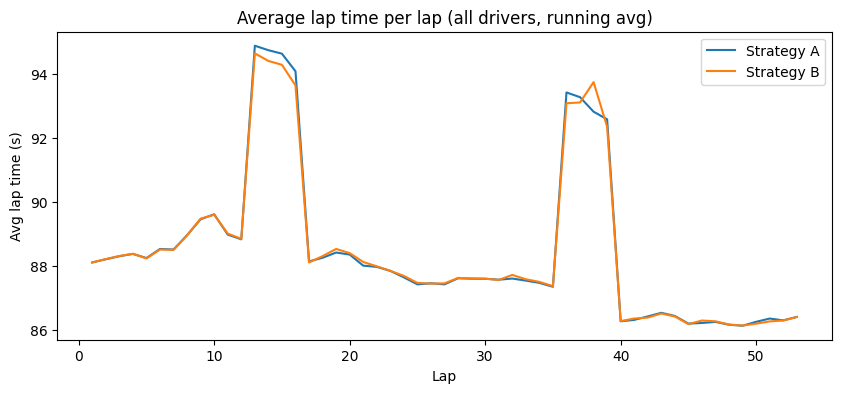

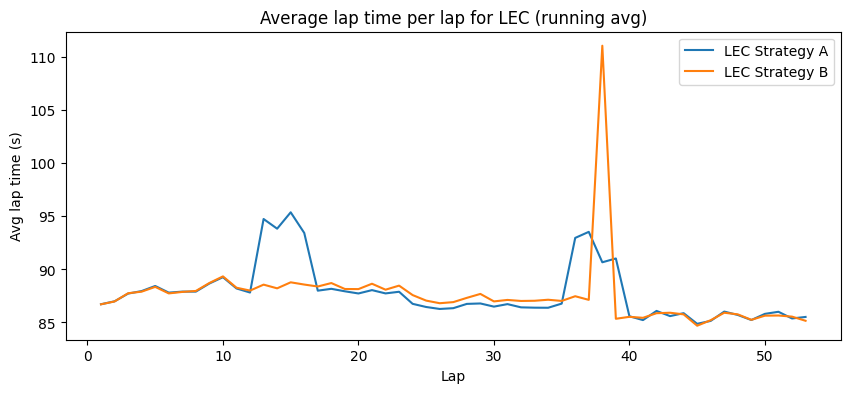

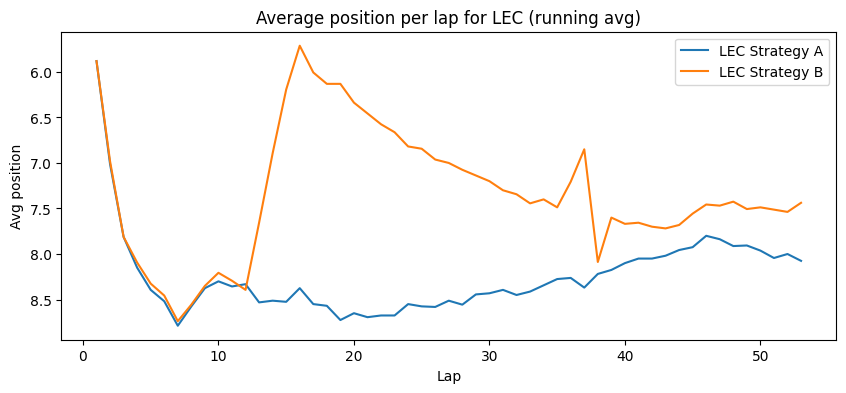

Strategy comparison:   8%|▊         | 168/2000 [03:41<40:14,  1.32s/it]


KeyboardInterrupt: 

In [39]:
# Strategy comparison (side-by-side Monte Carlo) with per-driver overrides
from IPython.display import display, clear_output
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def run_strategy_comparison(
    strategy_a_global,
    strategy_b_global,
    strategy_a_driver,
    strategy_b_driver,
    num_runs_compare=2000,
    race_length=60,
    update_every=20,
    circuit_id=None,
    year=None,
    grid=None,
):
    summary_comp = []

    lap_sum = {"A": np.zeros(race_length), "B": np.zeros(race_length)}
    lap_count = {"A": np.zeros(race_length), "B": np.zeros(race_length)}

    driver_lap_sum = {"A": {}, "B": {}}
    driver_lap_count = {"A": {}, "B": {}}

    driver_pos_sum = {"A": {}, "B": {}}
    driver_pos_count = {"A": {}, "B": {}}


    def driver_avg_lap(label, drv):
        total = driver_lap_sum[label].get(drv, 0.0)
        count = driver_lap_count[label].get(drv, 0.0)
        return total / count if count else np.nan

    custom_drivers = {
        "A": list(strategy_a_driver.keys()),
        "B": list(strategy_b_driver.keys()),
    }

    all_custom_drivers = sorted(set(custom_drivers.get('A', []) + custom_drivers.get('B', [])))

    custom_sum = {
        label: {drv: np.zeros(race_length) for drv in all_custom_drivers}
        for label in ['A', 'B']
    }
    custom_count = {
        label: {drv: np.zeros(race_length) for drv in all_custom_drivers}
        for label in ['A', 'B']
    }

    for run in tqdm(range(num_runs_compare), desc="Strategy comparison"):
        run_rng = np.random.default_rng(master_rng.integers(0, 1_000_000_000))
        chosen_circuit = circuit_id if circuit_id is not None else run_rng.choice(circuits)
        chosen_year = int(year) if year is not None else int(run_rng.choice(years_by_circuit.get(chosen_circuit, [2025])))
        chosen_grid = grid if grid is not None else grid_drivers

        configs = [
            ('A', strategy_a_global, strategy_a_driver),
            ('B', strategy_b_global, strategy_b_driver),
        ]

        base_seed = run_rng.integers(0, 1_000_000_000)
        for label, glob_strat, driver_strats in configs:
            rng_run = np.random.default_rng(base_seed)
            race_log, sc_laps, pit_loss_avg = simulate_race(
                circuit_id=chosen_circuit,
                grid_drivers=chosen_grid,
                total_laps=race_length,
                year=chosen_year,
                global_strategy=glob_strat,
                driver_strategies=driver_strats,
                safety_car_laps=None,
                rain_laps=None,
                pit_loss=None,
                rng=rng_run,
            )
            last_lap = race_log['lap'].max()
            final_class = race_log[race_log['lap'] == last_lap].sort_values('position')
            pit_by_driver = (
                race_log[race_log["pit_loss"] > 0]
                .groupby("driver_id")["pit_loss"]
                .agg(["sum", "count"])
                .to_dict("index")
            )
            for _, row in final_class.iterrows():
                summary_comp.append({
                    'run': run,
                    'strategy': label,
                    'circuit_id': chosen_circuit,
                    'year': chosen_year,
                    'driver_id': row['driver_id'],
                    'finish_pos': row['position'],
                    'dnf': bool(row['dnf']),
                    'sc_laps': len(sc_laps),
                    'pit_loss_avg': pit_loss_avg,
                    'pit_loss_sum': pit_by_driver.get(row['driver_id'], {}).get('sum', 0.0),
                    'pit_loss_count': pit_by_driver.get(row['driver_id'], {}).get('count', 0.0),
                })

            lap_stats = (
                race_log
                .dropna(subset=['lap_time'])
                .groupby('lap')['lap_time']
                .agg(['sum', 'count'])
                .reindex(range(1, race_length + 1), fill_value=0.0)
            )
            lap_sum[label] += lap_stats['sum'].to_numpy()
            lap_count[label] += lap_stats['count'].to_numpy()

            driver_stats = (
                race_log
                .dropna(subset=['lap_time'])
                .groupby('driver_id')['lap_time']
                .agg(['sum', 'count'])
            )
            for drv, row in driver_stats.iterrows():
                driver_lap_sum[label][drv] = driver_lap_sum[label].get(drv, 0.0) + float(row['sum'])
                driver_lap_count[label][drv] = driver_lap_count[label].get(drv, 0.0) + float(row['count'])

            driver_pos_stats = (
                race_log
                .dropna(subset=['position'])
                .groupby(['driver_id', 'lap'])['position']
                .mean()
                .unstack(fill_value=np.nan)
                .reindex(columns=range(1, race_length + 1))
            )
            for drv in driver_pos_stats.index:
                pos_vals = driver_pos_stats.loc[drv].to_numpy(dtype=float)
                pos_sum = driver_pos_sum[label].get(drv)
                pos_cnt = driver_pos_count[label].get(drv)
                if pos_sum is None:
                    pos_sum = np.zeros(race_length)
                    pos_cnt = np.zeros(race_length)
                mask = ~np.isnan(pos_vals)
                pos_sum[mask] += pos_vals[mask]
                pos_cnt[mask] += 1
                driver_pos_sum[label][drv] = pos_sum
                driver_pos_count[label][drv] = pos_cnt

            for drv in all_custom_drivers:
                drv_stats = (
                    race_log[race_log['driver_id'] == drv]
                    .dropna(subset=['lap_time'])
                    .groupby('lap')['lap_time']
                    .agg(['sum', 'count'])
                    .reindex(range(1, race_length + 1), fill_value=0.0)
                )
                custom_sum[label][drv] += drv_stats['sum'].to_numpy()
                custom_count[label][drv] += drv_stats['count'].to_numpy()

        if (run + 1) % update_every == 0 or run == num_runs_compare - 1:
            summary_comp_df = pd.DataFrame(summary_comp)
            wins = summary_comp_df[summary_comp_df['finish_pos'] == 1].groupby('strategy')['driver_id'].count()
            avg_finish = summary_comp_df.groupby(['driver_id', 'strategy'])['finish_pos'].mean().unstack()
            avg_finish['delta_B_minus_A'] = avg_finish.get('B', np.nan) - avg_finish.get('A', np.nan)
            avg_finish['avg_lap_time_A'] = [driver_avg_lap('A', drv) for drv in avg_finish.index]
            avg_finish['avg_lap_time_B'] = [driver_avg_lap('B', drv) for drv in avg_finish.index]
            dnf_counts = summary_comp_df.groupby(['driver_id', 'strategy'])['dnf'].sum().unstack()
            avg_finish['dnf_A'] = dnf_counts.get('A')
            avg_finish['dnf_B'] = dnf_counts.get('B')
            sc_by_run = summary_comp_df[['run', 'strategy', 'sc_laps']].drop_duplicates()
            runs_a = sc_by_run[sc_by_run['strategy'] == 'A']['run'].nunique()
            runs_b = sc_by_run[sc_by_run['strategy'] == 'B']['run'].nunique()
            sc_pct_a = (sc_by_run[sc_by_run['strategy'] == 'A']['sc_laps'].sum() * 100.0 / max(runs_a * race_length, 1))
            sc_pct_b = (sc_by_run[sc_by_run['strategy'] == 'B']['sc_laps'].sum() * 100.0 / max(runs_b * race_length, 1))
            avg_finish['sc_laps_A'] = sc_pct_a
            avg_finish['sc_laps_B'] = sc_pct_b
            pit_sum = summary_comp_df.groupby(['driver_id', 'strategy'])['pit_loss_sum'].sum().unstack()
            pit_count = summary_comp_df.groupby(['driver_id', 'strategy'])['pit_loss_count'].sum().unstack()
            avg_finish['pit_loss_A'] = pit_sum.get('A') / pit_count.get('A')
            avg_finish['pit_loss_B'] = pit_sum.get('B') / pit_count.get('B')
            clear_output(wait=True)
            print(f"Progress: {run + 1}/{num_runs_compare}")
            print("Wins per strategy:", wins)
            print("Average finish per driver (A vs B, lower is better):")
            display(avg_finish.sort_values('delta_B_minus_A'))

            laps_axis = np.arange(1, race_length + 1)
            fig, ax = plt.subplots(figsize=(10, 4))
            for label, color in [('A', '#1f77b4'), ('B', '#ff7f0e')]:
                avg_lap = lap_sum[label] / np.maximum(lap_count[label], 1)
                ax.plot(laps_axis, avg_lap, label=f"Strategy {label}", color=color)
            ax.set_xlabel('Lap')
            ax.set_ylabel('Avg lap time (s)')
            ax.set_title('Average lap time per lap (all drivers, running avg)')
            ax.legend()
            plt.show()

            all_custom_drivers = sorted(set(custom_drivers.get('A', []) + custom_drivers.get('B', [])))
            for drv in all_custom_drivers:
                fig, ax = plt.subplots(figsize=(10, 4))
                plotted = False
                for label, color in [('A', '#1f77b4'), ('B', '#ff7f0e')]:
                    avg_driver = custom_sum[label].get(drv, np.zeros(race_length)) / np.maximum(custom_count[label].get(drv, np.zeros(race_length)), 1)
                    if np.any(custom_count[label].get(drv, np.zeros(race_length))):
                        ax.plot(laps_axis, avg_driver, label=f"{drv} Strategy {label}", color=color)
                    else:
                        ax.plot(laps_axis, avg_driver, label=f"{drv} Strategy {label}", color=color, alpha=0.25)
                    plotted = True
                if plotted:
                    ax.set_xlabel('Lap')
                    ax.set_ylabel('Avg lap time (s)')
                    ax.set_title(f"Average lap time per lap for {drv} (running avg)")
                    ax.legend()
                    plt.show()

            for drv in all_custom_drivers:
                fig, ax = plt.subplots(figsize=(10, 4))
                plotted = False
                for label, color in [('A', '#1f77b4'), ('B', '#ff7f0e')]:
                    pos_sum = driver_pos_sum.get(label, {}).get(drv, np.zeros(race_length))
                    pos_cnt = driver_pos_count.get(label, {}).get(drv, np.zeros(race_length))
                    avg_pos = pos_sum / np.maximum(pos_cnt, 1)
                    if np.any(pos_cnt):
                        ax.plot(laps_axis, avg_pos, label=f"{drv} Strategy {label}", color=color)
                    else:
                        ax.plot(laps_axis, avg_pos, label=f"{drv} Strategy {label}", color=color, alpha=0.25)
                    plotted = True
                if plotted:
                    ax.set_xlabel('Lap')
                    ax.set_ylabel('Avg position')
                    ax.set_title(f"Average position per lap for {drv} (running avg)")
                    ax.invert_yaxis()
                    ax.legend()
                    plt.show()

    summary_comp_df = pd.DataFrame(summary_comp)

    wins = summary_comp_df[summary_comp_df['finish_pos'] == 1].groupby('strategy')['driver_id'].count()
    avg_finish = summary_comp_df.groupby(['driver_id', 'strategy'])['finish_pos'].mean().unstack()
    avg_finish['delta_B_minus_A'] = avg_finish.get('B', np.nan) - avg_finish.get('A', np.nan)
    avg_finish['avg_lap_time_A'] = [driver_avg_lap('A', drv) for drv in avg_finish.index]
    avg_finish['avg_lap_time_B'] = [driver_avg_lap('B', drv) for drv in avg_finish.index]
    dnf_counts = summary_comp_df.groupby(['driver_id', 'strategy'])['dnf'].sum().unstack()
    avg_finish['dnf_A'] = dnf_counts.get('A')
    avg_finish['dnf_B'] = dnf_counts.get('B')
    sc_by_run = summary_comp_df[['run', 'strategy', 'sc_laps']].drop_duplicates()
    runs_a = sc_by_run[sc_by_run['strategy'] == 'A']['run'].nunique()
    runs_b = sc_by_run[sc_by_run['strategy'] == 'B']['run'].nunique()
    sc_pct_a = (sc_by_run[sc_by_run['strategy'] == 'A']['sc_laps'].sum() * 100.0 / max(runs_a * race_length, 1))
    sc_pct_b = (sc_by_run[sc_by_run['strategy'] == 'B']['sc_laps'].sum() * 100.0 / max(runs_b * race_length, 1))
    avg_finish['sc_laps_A'] = sc_pct_a
    avg_finish['sc_laps_B'] = sc_pct_b

    pit_sum = summary_comp_df.groupby(['driver_id', 'strategy'])['pit_loss_sum'].sum().unstack()
    pit_count = summary_comp_df.groupby(['driver_id', 'strategy'])['pit_loss_count'].sum().unstack()
    avg_finish['pit_loss_A'] = pit_sum.get('A') / pit_count.get('A')
    avg_finish['pit_loss_B'] = pit_sum.get('B') / pit_count.get('B')

    print('Wins per strategy:', wins)
    print('Average finish per driver (A vs B, lower is better): ', avg_finish.sort_values('delta_B_minus_A'))

    laps_axis = np.arange(1, race_length + 1)
    fig, ax = plt.subplots(figsize=(10, 4))
    for label, color in [('A', '#1f77b4'), ('B', '#ff7f0e')]:
        avg_lap = lap_sum[label] / np.maximum(lap_count[label], 1)
        ax.plot(laps_axis, avg_lap, label=f"Strategy {label}", color=color)
    ax.set_xlabel('Lap')
    ax.set_ylabel('Avg lap time (s)')
    ax.set_title('Average lap time per lap (all drivers, all runs)')
    ax.legend()
    plt.show()

    for label in ['A', 'B']:
        for drv in custom_drivers.get(label, []):
            avg_driver = custom_sum[label][drv] / np.maximum(custom_count[label][drv], 1)
            fig, ax = plt.subplots(figsize=(10, 4))
            ax.plot(laps_axis, avg_driver, label=f"{drv} Strategy {label}")
            ax.set_xlabel('Lap')
            ax.set_ylabel('Avg lap time (s)')
            ax.set_title(f"Average lap time per lap for {drv} (Strategy {label})")
            ax.legend()
            plt.show()

    return summary_comp_df, avg_finish

strategy_a_global = [(0, 'SOFT'), (13, 16, 'MEDIUM'), (36, 39, 'MEDIUM')]
strategy_b_global = [(0, 'SOFT'), (13, 16, 'MEDIUM'), (36, 39, 'MEDIUM')]
# Optional per-driver overrides; leave empty to fall back to global strategy
strategy_a_driver = {}
strategy_b_driver = {
    "LEC": [(0, 'HARD'), (38, 'MEDIUM')],
}

num_runs_compare = 2000
race_length = 53
update_every = 20

summary_comp_df, avg_finish = run_strategy_comparison(
    strategy_a_global=strategy_a_global,
    strategy_b_global=strategy_b_global,
    strategy_a_driver=strategy_a_driver,
    strategy_b_driver=strategy_b_driver,
    num_runs_compare=num_runs_compare,
    race_length=race_length,
    update_every=update_every,
    year=2023,
    grid=None,
    circuit_id="monza"
)


MEDIUM -> SOFT -> -0.863158